# Let's get started! ⚡

In [ ]:
!pip install catboost

In [2]:
## IMPORT THE NECESSARY PYTHON LIBRARIES

# Exploratory Data Analysis
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin

# Catboost Training
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

In [3]:
# 데이터 읽어오기
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [4]:
# 헤드 확인
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 데이터의 컬럼 수 확인
print(df_train.shape, df_test.shape)

In [ ]:
# 컬럼별 타입과 Null값 확인
print(df_train.info())
print()
print(df_test.info())

# Data Preprocessing ⚙️🧹

In [5]:
# 'PassengerId' 컬럼 드랍 (상관관계 X)
# 제출할 때는 컬럼 다시 추가해줘야 합니다.
def drop_PassengerId(df_train):
    df_train = df_train.drop(columns=['PassengerId'])
    return df_train

In [6]:
# 'Name' 컬럼에서 'honorific_title' 컬럼 생성하기
# 의미있는 호칭(Mr, Mrs, Miss, Master)을 추출하는 과정입니다.

# 'honorific_title' 생성하는 함수
def get_honorific_title(name):
    top4_titles = ('Mr', 'Mrs', 'Miss', 'Master')

    # top4 호칭으로 바꿔줄 소수 여성 호칭
    female_titles_to_Mrs = ('Mme', 'the Countess', 'Dona', 'Lady')
    female_titles_to_Miss = ('Mlle', 'Ms')

    # top4 호칭으로 바꿔줄 소수 남성 호칭
    male_titles_to_Mr = ('Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev')

    # 예 : "Braund, Mr. Owen Harris"에서 'Mr' 추출
    # '.'(마침표) 기준으로 이름을 자르고, ','(콤마) 제거
    honorific_title = name.split('.')[0].split(', ')[-1]

    # 호칭에 따라 변환해서 리턴
    if honorific_title in top4_titles:
        return honorific_title
    elif honorific_title in female_titles_to_Mrs:
        return 'Mrs'
    elif honorific_title in female_titles_to_Miss:
        return 'Miss'
    elif honorific_title in male_titles_to_Mr:
        return 'Mr'
    else:
        return np.nan

In [7]:
# 새 피쳐로 사용할 컬럼 'honorific_title' 생성
def make_honorific_title(df_train, df_test):
    df_train['honorific_title'] = df_train['Name'].map(get_honorific_title)
    df_test['honorific_title'] = df_test['Name'].map(get_honorific_title)

    return df_train, df_test

In [8]:
# 원래 컬럼 'Name'를 드랍
def drop_Name(df_train, df_test):
    df_train = df_train.drop(columns=['Name'])
    df_test = df_test.drop(columns=['Name'])

    return df_train, df_test

In [9]:
# 새 컬럼 'Family' 계산해서 생성
def make_Family_column(df_train, df_test):
    df_train['Family'] = df_train['SibSp'].astype(int) + df_train['Parch'].astype(int) + 1
    df_test['Family'] = df_test['SibSp'].astype(int) + df_test['Parch'].astype(int) + 1

    return df_train, df_test

In [10]:
# 'SibSp' 컬럼 드랍
def drop_SibSp(df_train, df_test):
    df_train = df_train.drop(columns=['SibSp'])
    df_test = df_test.drop(columns=['SibSp'])

    return df_train, df_test

In [11]:
# 'Parch' 컬럼 드랍
def drop_Parch(df_train, df_test):
    df_train = df_train.drop(columns=['Parch'])
    df_test = df_test.drop(columns=['Parch'])

    return df_train, df_test

In [12]:
# 'Ticket' 컬럼 드랍 (의미를 찾을수 없음)
def drop_Ticket(df_train, df_test):
    df_train = df_train.drop(columns=['Ticket'])
    df_test = df_test.drop(columns=['Ticket'])

    return df_train, df_test

In [13]:
# 'Cabin' 컬럼 U로 채우고 매핑
def mapping_Cabin(df_train, df_test):
    # Cabin 빈칸 채우기
    df_train['Cabin'] = df_train['Cabin'].fillna('Unknown')
    df_test['Cabin'] = df_test['Cabin'].fillna('Unknown')

    # Cabin의 머리글자를 추출하고 매핑하기 위한 함수 생성
    cabin_mapping = {
        cabin[0]: idx for idx, cabin in enumerate(sorted(set(cabin[0] for cabin in df_train['Cabin'].unique())))
    }

    # 매핑 적용
    df_train['Cabin'] = df_train['Cabin'].map(lambda x : cabin_mapping[x[0]])
    df_test['Cabin'] = df_test['Cabin'].map(lambda x : cabin_mapping[x[0]])

    return df_train, df_test

In [14]:
# 'Age' 결측치 채우는 클래스
class AgeImputer(
    SimpleImputer, TransformerMixin
):
    """
    Age Imputer from 'honorific_title' column.

    There are four honorific titles: Mr, Mrs, Miss, Master.
    We proved that these groups have statistically different
    mean Ages (Independent T-tests).

    Imputation strategy:
        - fit:  compute the mean Age for each honorifit title
            Compute the mean Age for those who do not have title
        - transform:  if Age is missing for a passenger, if it has
            honorific title, the mean Age for that honorific title
            will be assigned. Else, the mean age for those who do
            not have title will be assigned.
    """

    def __init__(self) -> None:
        """
        Initialize an AgeImputer instance
        """

        # Initialize the parent Sklearn classes
        super().__init__()
        # Define the mappig {title_: mean Age for title_}
        self.title2age = {}
        # Define the mean age of those people with no title
        self.no_title_mean_age = None
        self.is_fitted = False


    def fit(self, X: pd.DataFrame, y=None):
        """
        Fits the 'title2age' and 'honorific_title' using 'X'.

        'X' is assumed to be Training Data (not Test Data!)
        'X' is assumed to be a non-empty data frame with
            (at least) the columns 'Age' and 'honorific_title'
        """

        df_groupby = df_train.groupby(
            by='honorific_title'
        ).agg({'Age': 'mean'})
        self.title2age = df_groupby.to_dict()['Age']

        if X['honorific_title'].isna().sum() == 0:
            self.no_title_mean_age = X['Age'].mean()
        else:
            self.no_title_mean_age = X.loc[
                X['honorific_title'].isna(), 'Age'
            ].mean()
        self.is_fitted = True
        return self


    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Transform 'X' by imputing the missing values of 'Age'

        'X' is assumed to be Training Data (not Test Data!)
        'X' is assumed to be a non-empty data frame with
            (at least) the columns 'Age' and 'honorific_title'
        """

        if not self.is_fitted:
            raise Exception("Call the 'fit' method first")

        X_out = X.copy(deep=True)
        missing_age_idx = X.loc[X['Age'].isna(), :].index
        age_col_idx = np.where(X.columns == 'Age')[0][0]

        for idx in missing_age_idx:

            # get the honorific_title of the 'idx' row
            title = X.loc[idx,'honorific_title']

            if title in self.title2age:
                X_out.loc[idx, 'Age'] = self.title2age[title]
            else:
                X_out.loc[idx, 'Age'] = self.no_title_mean_age

        return X_out['Age'].to_frame()

In [15]:
# Create three imputers : 결측치 채우는 함수를 imputer라고 합니다.
age_imputer = AgeImputer().set_output(transform='pandas')

fare_imputer = SimpleImputer(
    strategy='median'
).set_output(transform='pandas')

embarked_imputer = SimpleImputer(
    strategy='most_frequent'
).set_output(transform='pandas')


# Create a general imputer (for all the variables)
imputer = ColumnTransformer(
    transformers=[
        ('age_imp', age_imputer, ['Age', 'honorific_title']),
        ('fare_imp', fare_imputer, ['Fare']),
        ('embarked_imp', embarked_imputer, ['Embarked'])
    ],
    remainder='passthrough', # 나머지는 놔둔다.
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [16]:
# 'honorific_title' 한정 원핫 인코딩(나이 결측치 채우는 데 필요)
def make_honorific_title_dummy(df_train, df_test):
    df_train['dummy_honorific_title'] = df_train['honorific_title']
    df_train = pd.get_dummies(
          data=df_train
        , columns=['dummy_honorific_title']
        , prefix=''
        , prefix_sep=''
        , dummy_na=False  # Null 컬럼은 복사하지 않는다.
        , drop_first=False  # Top4 honorific titles 행은 전부 복사
        , dtype=int
    )

    df_test['dummy_honorific_title'] = df_test['honorific_title']
    df_test = pd.get_dummies(
          data=df_test
        , columns=['dummy_honorific_title']
        , prefix=''
        , prefix_sep=''
        , dummy_na=False  # Null 컬럼은 복사하지 않는다.
        , drop_first=False  # Top4 honorific titles 행은 전부 복사
        , dtype=int
    )

    return df_train, df_test

In [17]:
# 결측치 채우기 전 전처리 함수 모음
def before_impute_preprocessing(df_train, df_test):
    # 바로 드랍하는 컬럼들 드랍
    df_train = drop_PassengerId(df_train)
    # df_train, df_test = drop_Cabin(df_train, df_test)
    df_train, df_test = drop_Ticket(df_train, df_test)

    # 전처리 후 인코딩하는 컬럼
    df_train, df_test = make_honorific_title(df_train, df_test)
    df_train, df_test = drop_Name(df_train, df_test)
    df_train, df_test = mapping_Cabin(df_train, df_test)

    # 'Family' 컬럼 만들고 필요없는 컬럼 드랍
    df_train, df_test = make_Family_column(df_train, df_test)
    df_train, df_test = drop_SibSp(df_train, df_test)
    df_train, df_test = drop_Parch(df_train, df_test)

    # honorific_title의 더미 컬럼 생성
    df_train, df_test = make_honorific_title_dummy(df_train, df_test)

    return df_train, df_test

In [18]:
# 결측치 채우기 전 전처리 함수 실행
df_train, df_test = before_impute_preprocessing(df_train, df_test)

In [19]:
# 결측치 채우기
df_train = pd.DataFrame(
      imputer.fit_transform(df_train)
    , columns=df_train.columns
)

df_test = pd.DataFrame(
      imputer.fit_transform(df_test)
    , columns=df_test.columns
)

In [20]:
# 'avg_Fare_by_50' 컬럼 생성 함수
def make_avg_Fare_by_50(df_train, df_test):
    df_train['avg_Fare_by_50'] = round(df_train['Fare'] / (df_train['Family'] * 50) + 1.0e-10)
    df_test['avg_Fare_by_50'] = round(df_test['Fare'] / (df_test['Family'] * 50) + 1.0e-10)

    return df_train, df_test

In [21]:
# 'avg_Fare_by_50' 레이블 인코딩 함수
def label_encoding_avg_Fare(df_train, df_test):
    def categorize_avg_Fare(x):
        if x == 0:
            return 'Cheap'
        else:
            return 'Expensive'

    df_train['avg_Fare_by_50'] = df_train['avg_Fare_by_50'].map(categorize_avg_Fare)
    df_test['avg_Fare_by_50'] = df_test['avg_Fare_by_50'].map(categorize_avg_Fare)

    return df_train, df_test

In [22]:
# 'Fare' 컬럼 드랍
def drop_Fare(df_train, df_test):
    df_train = df_train.drop(columns=['Fare'])
    df_test = df_test.drop(columns=['Fare'])

    return df_train, df_test

In [23]:
# 'Famliy' 컬럼 레이블 인코딩
def label_encoding_Family(df_train, df_test):
    df_train['Family'] = df_train['Family'].map(
        lambda f : str(f) if f < 3 else '>=3'
    )

    df_test['Family'] = df_test['Family'].map(
        lambda f : str(f) if f < 3 else '>=3'
    )

    return df_train, df_test

In [24]:
# 결측치 채운 후 전처리 함수 모음
def after_impute_preprocessing(df_train, df_test):
    # 'Fare' 컬럼 레이블 인코딩
    df_train, df_test = make_avg_Fare_by_50(df_train, df_test)
    df_train, df_test = label_encoding_avg_Fare(df_train, df_test)

    # 'Fare' 컬럼 드랍
    df_train, df_test = drop_Fare(df_train, df_test)

    # 'Family' 컬럼 레이블 인코딩
    df_train, df_test = label_encoding_Family(df_train, df_test)

    return df_train, df_test

In [25]:
# 두번째 전처리 함수 호출
df_train, df_test = after_impute_preprocessing(df_train, df_test)

# CatBoost Training 🏋️‍♂️🌲

In [26]:
# 학습데이터의 데이터와 답 분리
X_train = df_train.drop(columns=['Survived'])
y_train = df_train['Survived']

In [27]:
# Catboost 모델의 학습 피쳐 리스트 입력
cat_features = [
    'Sex', 'Embarked', 'Pclass', 'Cabin',
    'Family', 'avg_Fare_by_50',
    'Master', 'Miss', 'Mr', 'Mrs'
]

In [28]:
# RandomizedSearchCV 파라미터 세팅:

# Number of parameter settings that are sampled
# 'n_iter' (런타임 vs 답의 퀄리티) 사이에 트레이드오프 발생
# NOTE: 여기서 10을 쓴 건 이 노트북을 실습하는 분들이 빠르게 돌려보라고 넣은 것입니다. 숫자 꼭 바꾸세요!
n_iter = 30  # 추천: 30에서 60 사이

# Number of folds in the cross-validation splitting strategy
cv = 6  # 추천 : 4에서 10 사이

In [29]:
# 하이퍼 파라미터의 grid values 세팅
catboost_hparams = {
    'catboost_clf__n_estimators': [
        100, 200, 300
    ],
    'catboost_clf__depth': [
        4, 8, 12
    ],
    'catboost_clf__learning_rate': stats.uniform(
        loc=0.01, scale=0.99
    ),
    'catboost_clf__l2_leaf_reg': stats.uniform(
        loc=1, scale=9
    )
}

In [30]:
# basic CatBoost Classifier 클래스 생성
catboost_clf = CatBoostClassifier(
    cat_features=cat_features,
    verbose=0
)

In [33]:
# Concatenate the Imputer and the Classifier
# Sklearn Pipeline 사용
catboost_pipe = Pipeline(steps=[
    # ('imputer', imputer),
    ('catboost_clf', catboost_clf)
])

# Define the Randomized Search with Cross-Validation
catboost_cv = RandomizedSearchCV(
    estimator=catboost_pipe,
    param_distributions=catboost_hparams,
    n_iter=n_iter,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    verbose=0,
)

In [34]:
# Run the Randomized Search with Cross-Validation
catboost_cv.fit(X=X_train, y=y_train)

# Print the results:
print('CatBoost best params:', catboost_cv.best_params_)
print()
print('CatBoost best cv accuracy:', catboost_cv.best_score_)

CatBoost best params: {'catboost_clf__depth': 4, 'catboost_clf__l2_leaf_reg': 5.411807628920013, 'catboost_clf__learning_rate': 0.09266634761049038, 'catboost_clf__n_estimators': 300}

CatBoost best cv accuracy: 0.8216034826773081


Text(0.5, 1.0, 'CatBoost Feature Importance')

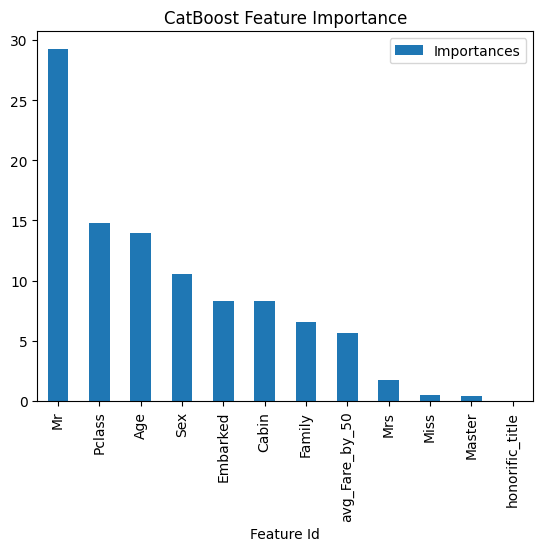

In [35]:
# Feature Importance 시각화
feature_importance = catboost_cv.best_estimator_.named_steps[
    'catboost_clf'
].get_feature_importance(
    type='FeatureImportance',
    prettified=True
)

feature_importance.plot.bar(x='Feature Id', y='Importances')
plt.title('CatBoost Feature Importance')

# Submission File 🏆🎯

In [36]:
# 위에서 찾은 최적의 hyperparameters set을 이용한 최고의 모델 생성

final_catboost_clf = CatBoostClassifier(
    n_estimators=300,
    depth=4,
    learning_rate=0.09266634761049038,
    l2_leaf_reg=5.411807628920013,
    cat_features=cat_features,
    random_state=42,
    verbose=0
)

final_catboost_pipe = Pipeline(steps=[
    # ('imputer', imputer),
    ('catboost_clf', catboost_clf)
])

# 생성된 최종 모델에 학습데이터를 넣어서 학습
final_catboost_pipe.fit(X_train, y_train)

Pipeline(steps=[('catboost_clf',
                 <catboost.core.CatBoostClassifier object at 0x7c1d5d2a02e0>)])

In [37]:
# 테스트데이터 넣어서 예측
predictions = final_catboost_pipe.predict(
    df_test.drop(columns=['PassengerId'])
)

In [38]:
# 제출파일 준비: PassengerId - Survived
submission = pd.DataFrame({
    'PassengerId' : df_test['PassengerId'],
    'Survived' : predictions
})

submission['Survived'] = submission['Survived'].astype(int)

In [39]:
# 제출파일 저장
submission.to_csv('submission.csv', index=False)
print('your submission file is saved!')

your submission file is saved!


## 채점하기

In [40]:
# 생성된 데이터 파일과 솔루션 불러오기
# 파일 경로 적절히 수정해서 쓰세요.
submission = pd.read_csv('./submission.csv')
solution = pd.read_csv('./solution.csv')

In [41]:
# 채점 테이블 생성
marking = submission.merge(solution, on='PassengerId')
marking.columns = ['PassengerId', 'Submission', 'Solution']

# 'Check' : 맞으면 1, 틀리면 0
marking['Check'] = 0

In [42]:
# 채점
cond = marking['Submission'] == marking['Solution']
marking.loc[cond, 'Check'] = 1

# 정답 계산 및 출력
result = marking['Check'].sum() / marking.shape[0]
print('정답: {0:.5f}'.format(result))

정답: 0.78947
